In [2]:
import os
from pathlib import Path
import random
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from torchvision import transforms
from torchvision.models import resnet50, ResNet50_Weights
from PIL import Image, ImageFile

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt

ImageFile.LOAD_TRUNCATED_IMAGES = True


In [3]:
CONFIG = {
    "img_size": 224,
    "batch_size": 32,
    "epochs": 50,            # max epochs (early stopping will stop earlier)
    "lr": 3e-4,              # more stable than 1e-3 for AdamW
    "weight_decay": 1e-4,
    "seed": 42,
    "val_size": 0.15,
    "test_size": 0.15,
    "num_workers": 0,        # Windows safe default

    # training control
    "patience": 7,           # early stopping patience
    "min_delta": 1e-4,       # minimum val_loss improvement
    "min_epochs": 5,         # warmup before early stopping
    "clip_grad_norm": 1.0,   # gradient clipping
}

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(CONFIG["seed"])

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

CONFIG


Device: cpu


{'img_size': 224,
 'batch_size': 32,
 'epochs': 50,
 'lr': 0.0003,
 'weight_decay': 0.0001,
 'seed': 42,
 'val_size': 0.15,
 'test_size': 0.15,
 'num_workers': 0,
 'patience': 7,
 'min_delta': 0.0001,
 'min_epochs': 5,
 'clip_grad_norm': 1.0}

In [4]:
# Paths + output folders

DATA_DIR = Path("data")
USD_DIR = DATA_DIR / "USD"
THB_DIR = DATA_DIR / "THB"

SPLITS_DIR = DATA_DIR / "splits"
OUT_DIR = Path("outputs") / "rq1"

SPLITS_DIR.mkdir(parents=True, exist_ok=True)
(OUT_DIR / "usd").mkdir(parents=True, exist_ok=True)
(OUT_DIR / "thb").mkdir(parents=True, exist_ok=True)

print("USD exists:", USD_DIR.exists(), USD_DIR)
print("THB exists:", THB_DIR.exists(), THB_DIR)

# Unseen test set directory (final evaluation ONLY)
TEST_DIR = Path("test")       
USD_TEST_DIR = TEST_DIR / "USD"
THB_TEST_DIR = TEST_DIR / "THB"


print("USD unseen test exists:", USD_TEST_DIR.exists(), USD_TEST_DIR)
print("THB unseen test exists:", THB_TEST_DIR.exists(), THB_TEST_DIR)




USD exists: True data\USD
THB exists: True data\THB
USD unseen test exists: True test\USD
THB unseen test exists: True test\THB


In [5]:
IMG_EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

def build_index(currency_name: str, currency_dir: Path) -> pd.DataFrame:
    rows = []
    class_dirs = [p for p in currency_dir.iterdir() if p.is_dir()]
    class_dirs = sorted(class_dirs, key=lambda p: p.name)

    for class_dir in class_dirs:
        label = class_dir.name  # class is the folder name
        for img_path in class_dir.rglob("*"):
            if img_path.suffix.lower() in IMG_EXTS:
                rows.append({
                    "path": str(img_path),
                    "currency": currency_name,
                    "label": label
                })

    df = pd.DataFrame(rows)
    return df

usd_df = build_index("USD", USD_DIR)
thb_df = build_index("THB", THB_DIR)

usd_test_df = build_index("USD", USD_TEST_DIR)
thb_test_df = build_index("THB", THB_TEST_DIR)


print("USD images:", len(usd_df), "| classes:", usd_df["label"].nunique() if len(usd_df) else 0)
print("THB images:", len(thb_df), "| classes:", thb_df["label"].nunique() if len(thb_df) else 0)

print("USD unseen test images:", len(usd_test_df), "| classes:", usd_test_df["label"].nunique() if len(usd_test_df) else 0)
print("THB unseen test images:", len(thb_test_df), "| classes:", thb_test_df["label"].nunique() if len(thb_test_df) else 0)

usd_df.head()


USD images: 800 | classes: 5
THB images: 800 | classes: 5
USD unseen test images: 200 | classes: 5
THB unseen test images: 200 | classes: 5


,path,currency,label
0,data\USD\10 Dollar\10_Dollar_001.jpg,USD,10 Dollar
1,data\USD\10 Dollar\10_Dollar_002.jpg,USD,10 Dollar
2,data\USD\10 Dollar\10_Dollar_003.jpg,USD,10 Dollar
3,data\USD\10 Dollar\10_Dollar_004.jpg,USD,10 Dollar
4,data\USD\10 Dollar\10_Dollar_005.jpg,USD,10 Dollar


label
10 Dollar     160
100 Dollar    160
2 Dollar      160
5 Dollar      160
50 Dollar     160
Name: count, dtype: int64

label
THAI100     160
THAI1000    160
THAI20      160
THAI50      160
THAI500     160
Name: count, dtype: int64

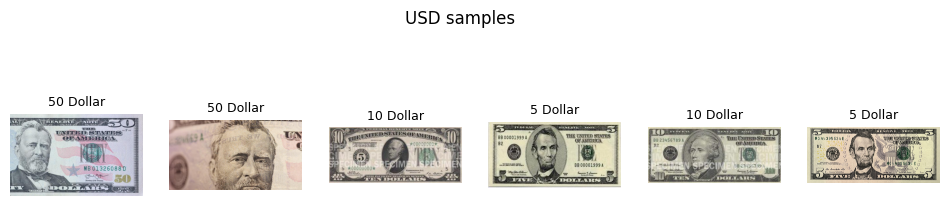

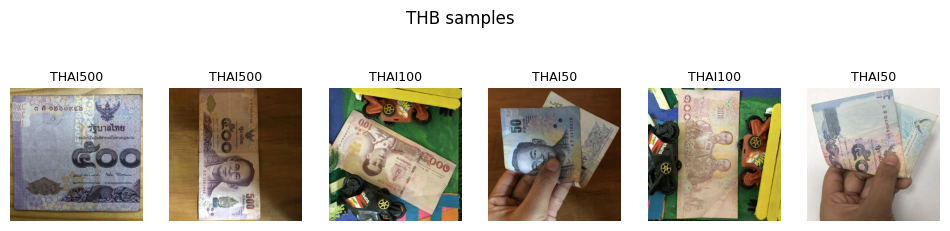

In [6]:
display(usd_df["label"].value_counts())
display(thb_df["label"].value_counts())

def show_samples(df: pd.DataFrame, n=6, title="Samples"):
    if len(df) == 0:
        print("No images found.")
        return
    sample = df.sample(n=min(n, len(df)), random_state=CONFIG["seed"])
    plt.figure(figsize=(12, 3))
    for i, row in enumerate(sample.itertuples(index=False), 1):
        img = Image.open(row.path).convert("RGB")
        plt.subplot(1, min(n, len(sample)), i)
        plt.imshow(img)
        plt.title(row.label, fontsize=9)
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

show_samples(usd_df, title="USD samples")
show_samples(thb_df, title="THB samples")


In [7]:
def make_train_val_split(df: pd.DataFrame):
    train, val = train_test_split(
        df,
        test_size=0.30,                # your new 70/30 train/val
        random_state=CONFIG["seed"],
        stratify=df["label"]
    )
    return train.reset_index(drop=True), val.reset_index(drop=True)

def assert_all_classes_present_train_val(train_df, val_df, name="dataset"):
    train_classes = set(train_df["label"])
    val_classes = set(val_df["label"])
    missing_val = val_classes - train_classes

    print(f"{name} classes: train={len(train_classes)}, val={len(val_classes)}")
    print(f"Missing from train (val): {missing_val}")

    assert len(missing_val) == 0, f"{name}: Some classes are missing from train."


usd_train, usd_val = make_train_val_split(usd_df)
thb_train, thb_val = make_train_val_split(thb_df)

print("USD train/val:", len(usd_train), len(usd_val))
print("THB train/val:", len(thb_train), len(thb_val))

assert_all_classes_present_train_val(usd_train, usd_val, name="USD")
assert_all_classes_present_train_val(thb_train, thb_val, name="THB")



USD train/val: 560 240
THB train/val: 560 240
USD classes: train=5, val=5
Missing from train (val): set()
THB classes: train=5, val=5
Missing from train (val): set()


In [8]:
usd_train.to_csv(SPLITS_DIR / "usd_train.csv", index=False)
usd_val.to_csv(SPLITS_DIR / "usd_val.csv", index=False)

thb_train.to_csv(SPLITS_DIR / "thb_train.csv", index=False)
thb_val.to_csv(SPLITS_DIR / "thb_val.csv", index=False)

# Save unseen test indexes too (for reproducibility)
usd_test_df.to_csv(SPLITS_DIR / "usd_unseen_test.csv", index=False)
thb_test_df.to_csv(SPLITS_DIR / "thb_unseen_test.csv", index=False)

print("Saved train/val splits + unseen test index files to:", SPLITS_DIR.resolve())



Saved train/val splits + unseen test index files to: C:\Users\brand\Downloads\ML_Currency_Detection\data\splits


In [9]:
train_tfms = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.RandomRotation(180),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

eval_tfms = transforms.Compose([
    transforms.Resize((CONFIG["img_size"], CONFIG["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


In [10]:
class CurrencyDataset(Dataset):
    def __init__(self, df: pd.DataFrame, class_to_idx: dict, tfms):
        self.df = df.reset_index(drop=True)
        self.class_to_idx = class_to_idx
        self.tfms = tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        x = self.tfms(img)
        y = self.class_to_idx[row["label"]]
        return x, y

def make_loaders(train_df, val_df, unseen_test_df):
    classes = sorted(train_df["label"].unique())
    class_to_idx = {c: i for i, c in enumerate(classes)}
    idx_to_class = {i: c for c, i in class_to_idx.items()}

    # Ensure unseen test contains no unseen labels
    unseen_labels = set(unseen_test_df["label"]) - set(classes)
    assert len(unseen_labels) == 0, f"Unseen test has labels not in training: {unseen_labels}"

    train_ds = CurrencyDataset(train_df, class_to_idx, train_tfms)
    val_ds   = CurrencyDataset(val_df, class_to_idx, eval_tfms)
    test_ds  = CurrencyDataset(unseen_test_df, class_to_idx, eval_tfms)

    train_loader = DataLoader(train_ds, batch_size=CONFIG["batch_size"], shuffle=True,  num_workers=CONFIG["num_workers"])
    val_loader   = DataLoader(val_ds,   batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])
    test_loader  = DataLoader(test_ds,  batch_size=CONFIG["batch_size"], shuffle=False, num_workers=CONFIG["num_workers"])

    return train_loader, val_loader, test_loader, class_to_idx, idx_to_class


usd_train_loader, usd_val_loader, usd_test_loader, usd_class_to_idx, usd_idx_to_class = make_loaders(
    usd_train, usd_val, usd_test_df
)

thb_train_loader, thb_val_loader, thb_test_loader, thb_class_to_idx, thb_idx_to_class = make_loaders(
    thb_train, thb_val, thb_test_df
)


print("USD num classes:", len(usd_class_to_idx))
print("THB num classes:", len(thb_class_to_idx))

x, y = next(iter(usd_train_loader))
print("USD batch:", x.shape, y.shape)
print("THB batch:", x.shape, y.shape)


USD num classes: 5
THB num classes: 5
USD batch: torch.Size([32, 3, 224, 224]) torch.Size([32])
THB batch: torch.Size([32, 3, 224, 224]) torch.Size([32])


In [11]:
def build_model(num_classes: int):
    model = resnet50(weights=ResNet50_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model.to(device)


In [12]:
def train_one_currency(
    train_loader,
    val_loader,
    num_classes: int,
    patience: int = 5,
    min_delta: float = 0.0,
):
    model = build_model(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=CONFIG["lr"],
        weight_decay=CONFIG["weight_decay"]
    )

    best_val_loss = float("inf")
    best_state = None
    history = []

    epochs_no_improve = 0

    for epoch in range(1, CONFIG["epochs"] + 1):
        # Train
        model.train()
        train_loss_sum, train_correct, train_total = 0.0, 0, 0

        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad(set_to_none=True)
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            optimizer.step()

            bs = y.size(0)
            train_loss_sum += loss.item() * bs
            train_correct += (logits.argmax(1) == y).sum().item()
            train_total += bs

        train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total

        # Val
        model.eval()
        val_loss_sum, val_correct, val_total = 0.0, 0, 0

        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                loss = criterion(logits, y)

                bs = y.size(0)
                val_loss_sum += loss.item() * bs
                val_correct += (logits.argmax(1) == y).sum().item()
                val_total += bs

        val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total

        history.append({
            "epoch": epoch,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "val_loss": val_loss,
            "val_acc": val_acc
        })

        print(
            f"Epoch {epoch:02d} | "
            f"train_loss={train_loss:.4f} train_acc={train_acc:.4f} | "
            f"val_loss={val_loss:.4f} val_acc={val_acc:.4f}"
        )

        # Early stopping --> improvement must be at least min_delta
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(
                f"Early stopping at epoch {epoch:02d} "
                f"(no improvement for {patience} epochs). Best val_loss={best_val_loss:.4f}"
            )
            break

    # Restore best weights
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, pd.DataFrame(history)


In [13]:
usd_model, usd_hist = train_one_currency(
    usd_train_loader, usd_val_loader, num_classes=len(usd_class_to_idx)
)

usd_hist.to_csv(OUT_DIR / "usd" / "history.csv", index=False)
torch.save(usd_model.state_dict(), OUT_DIR / "usd" / "best.pt")

usd_hist.tail()


Epoch 01 | train_loss=1.2031 train_acc=0.6161 | val_loss=0.6530 val_acc=0.7292
Epoch 02 | train_loss=0.2908 train_acc=0.9304 | val_loss=0.0863 val_acc=0.9792
Epoch 03 | train_loss=0.0974 train_acc=0.9839 | val_loss=0.1840 val_acc=0.9083
Epoch 04 | train_loss=0.0677 train_acc=0.9768 | val_loss=0.0643 val_acc=0.9833
Epoch 05 | train_loss=0.0439 train_acc=0.9893 | val_loss=0.1915 val_acc=0.9417
Epoch 06 | train_loss=0.0552 train_acc=0.9839 | val_loss=0.0972 val_acc=0.9792
Epoch 07 | train_loss=0.0471 train_acc=0.9875 | val_loss=0.1323 val_acc=0.9667
Epoch 08 | train_loss=0.0608 train_acc=0.9839 | val_loss=0.1152 val_acc=0.9583
Epoch 09 | train_loss=0.0394 train_acc=0.9911 | val_loss=0.0493 val_acc=0.9875
Epoch 10 | train_loss=0.0411 train_acc=0.9839 | val_loss=0.0801 val_acc=0.9708
Epoch 11 | train_loss=0.0322 train_acc=0.9929 | val_loss=0.0509 val_acc=0.9833
Epoch 12 | train_loss=0.0284 train_acc=0.9929 | val_loss=0.0626 val_acc=0.9792
Epoch 13 | train_loss=0.0465 train_acc=0.9875 | val_

,epoch,train_loss,train_acc,val_loss,val_acc
9,10,0.041092,0.983929,0.080114,0.970833
10,11,0.032190,0.992857,0.050914,0.983333
11,12,0.028413,0.992857,0.062609,0.979167
12,13,0.046523,0.987500,0.065381,0.979167
13,14,0.017147,0.996429,0.055631,0.983333


In [14]:
thb_model, thb_hist = train_one_currency(
    thb_train_loader, thb_val_loader, num_classes=len(thb_class_to_idx)
)

thb_hist.to_csv(OUT_DIR / "thb" / "history.csv", index=False)
torch.save(thb_model.state_dict(), OUT_DIR / "thb" / "best.pt")

thb_hist.tail()


Epoch 01 | train_loss=1.3347 train_acc=0.5071 | val_loss=0.4523 val_acc=0.9458
Epoch 02 | train_loss=0.4068 train_acc=0.9036 | val_loss=0.2695 val_acc=0.8875
Epoch 03 | train_loss=0.2096 train_acc=0.9411 | val_loss=0.0796 val_acc=0.9708
Epoch 04 | train_loss=0.1339 train_acc=0.9536 | val_loss=0.1614 val_acc=0.9458
Epoch 05 | train_loss=0.0654 train_acc=0.9768 | val_loss=0.0665 val_acc=0.9833
Epoch 06 | train_loss=0.0344 train_acc=0.9929 | val_loss=0.0333 val_acc=0.9875
Epoch 07 | train_loss=0.0860 train_acc=0.9696 | val_loss=0.0278 val_acc=0.9875
Epoch 08 | train_loss=0.0504 train_acc=0.9893 | val_loss=0.0317 val_acc=0.9833
Epoch 09 | train_loss=0.0392 train_acc=0.9857 | val_loss=0.0379 val_acc=0.9833
Epoch 10 | train_loss=0.0738 train_acc=0.9732 | val_loss=0.0448 val_acc=0.9875
Epoch 11 | train_loss=0.0682 train_acc=0.9839 | val_loss=0.0721 val_acc=0.9833
Epoch 12 | train_loss=0.0602 train_acc=0.9786 | val_loss=0.0655 val_acc=0.9833
Early stopping at epoch 12 (no improvement for 5 epo

,epoch,train_loss,train_acc,val_loss,val_acc
7,8,0.050394,0.989286,0.031695,0.983333
8,9,0.039214,0.985714,0.037858,0.983333
9,10,0.073814,0.973214,0.044801,0.987500
10,11,0.068154,0.983929,0.072051,0.983333
11,12,0.060237,0.978571,0.065525,0.983333


In [15]:
def evaluate(model, test_loader, idx_to_class):
    model.eval()
    all_true = []
    all_pred = []

    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            logits = model(x)
            preds = logits.argmax(1).cpu().numpy()
            all_pred.extend(preds)
            all_true.extend(y.numpy())

    all_true = np.array(all_true)
    all_pred = np.array(all_pred)

    acc = accuracy_score(all_true, all_pred)
    cm = confusion_matrix(all_true, all_pred, labels=list(range(len(idx_to_class))))


    per_class = []
    for i in range(len(idx_to_class)):
        label = idx_to_class[i]
        row_sum = cm[i].sum()
        class_acc = (cm[i, i] / row_sum) if row_sum > 0 else np.nan
        per_class.append({"class": label, "acc": class_acc})

    per_class_df = pd.DataFrame(per_class).sort_values("acc")
    macro_per_class = float(np.nanmean(per_class_df["acc"]))
    return acc, macro_per_class, cm, per_class_df

usd_acc, usd_macro, usd_cm, usd_per_class = evaluate(usd_model, usd_test_loader, usd_idx_to_class)
thb_acc, thb_macro, thb_cm, thb_per_class = evaluate(thb_model, thb_test_loader, thb_idx_to_class)

print("USD test accuracy:", usd_acc, "| macro per-class:", usd_macro)
print("THB test accuracy:", thb_acc, "| macro per-class:", thb_macro)


USD test accuracy: 1.0 | macro per-class: 1.0
THB test accuracy: 0.97 | macro per-class: 0.97


In [19]:
RQ1_OUT = Path("outputs") / "rq1"
RQ1_OUT.mkdir(parents=True, exist_ok=True)

rq1_summary = pd.DataFrame([
    {"currency": "USD", "model": "Baseline (separate)", "test_accuracy": float(usd_acc), "macro_per_class_acc": float(usd_macro)},
    {"currency": "THB", "model": "Baseline (separate)", "test_accuracy": float(thb_acc), "macro_per_class_acc": float(thb_macro)},
])

rq1_summary_path = RQ1_OUT / "rq1_summary_latest.csv"
rq1_summary.to_csv(rq1_summary_path, index=False)

display(rq1_summary)
print("Saved to:", rq1_summary_path.resolve())

,currency,model,test_accuracy,macro_per_class_acc
0,USD,Baseline (separate),1.00,1.00
1,THB,Baseline (separate),0.97,0.97


Saved to: C:\Users\brand\Downloads\ML_Currency_Detection\outputs\rq1\rq1_summary_latest.csv


In [17]:
usd_per_class.to_csv(OUT_DIR / "usd" / "per_class.csv", index=False)
thb_per_class.to_csv(OUT_DIR / "thb" / "per_class.csv", index=False)

summary = pd.DataFrame([
    {"currency": "USD", "test_accuracy": usd_acc, "macro_per_class_acc": usd_macro},
    {"currency": "THB", "test_accuracy": thb_acc, "macro_per_class_acc": thb_macro},
])

summary.to_csv(OUT_DIR / "rq1_summary.csv", index=False)
summary


,currency,test_accuracy,macro_per_class_acc
0,USD,1.00,1.00
1,THB,0.97,0.97


In [18]:
print("USD hardest classes (lowest 5):")
display(usd_per_class.head(5))

print("THB hardest classes (lowest 5):")
display(thb_per_class.head(5))


USD hardest classes (lowest 5):


,class,acc
0,10 Dollar,1.0
1,100 Dollar,1.0
2,2 Dollar,1.0
3,5 Dollar,1.0
4,50 Dollar,1.0


THB hardest classes (lowest 5):


,class,acc
0,THAI100,0.900
1,THAI1000,0.975
3,THAI50,0.975
2,THAI20,1.000
4,THAI500,1.000


In [ ]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

# 1. Helper to turn tensors back into viewable RGB images
def denormalize_image(tensor):
    # These must match the transforms.Normalize values you used in Cell 29
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    # Move to CPU, change shape from (3, 224, 224) to (224, 224, 3)
    img = tensor.permute(1, 2, 0).cpu().numpy()
    
    # Reverse the normalization math
    img = std * img + mean
    
    # Clip values to be strictly between 0 and 1 (removes math errors)
    img = np.clip(img, 0, 1)
    return img

def visualize_gradcam(model, loader, idx_to_class, device, num_images=5):
    model.eval()
    
    target_layers = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layers)
    
    # Collect ALL images from ALL batches
    all_images = []
    all_labels = []
    
    for batch_images, batch_labels in loader:
        all_images.append(batch_images)
        all_labels.append(batch_labels)
    
    # Concatenate all batches
    images = torch.cat(all_images, dim=0)
    labels = torch.cat(all_labels, dim=0)
    
    # Group by class to ensure diversity
    class_indices = {}
    for idx, label in enumerate(labels):
        class_id = label.item()
        if class_id not in class_indices:
            class_indices[class_id] = []
        class_indices[class_id].append(idx)
    
    # Select TWO images per class
    selected_indices = []
    for class_id in sorted(class_indices.keys()):
        # Pick 2 random images from this class
        class_size = len(class_indices[class_id])
        for _ in range(2):
            if len(selected_indices) < num_images:
                idx = class_indices[class_id][torch.randint(0, class_size, (1,)).item()]
                selected_indices.append(idx)
    
    plt.figure(figsize=(20, 4 * len(selected_indices)))
    
    for plot_idx, img_idx in enumerate(selected_indices):
        input_tensor = images[img_idx].unsqueeze(0).to(device)
        
        with torch.no_grad():
            logits = model(input_tensor)
            pred_idx = logits.argmax(dim=1).item()
            confidence = torch.softmax(logits, dim=1).max().item()
            
        pred_label = idx_to_class[pred_idx]
        true_label = idx_to_class[labels[img_idx].item()]
        
        grayscale_cam = cam(input_tensor=input_tensor, targets=None)
        grayscale_cam = grayscale_cam[0, :]
        
        rgb_img = denormalize_image(images[img_idx])
        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
        
        ax = plt.subplot(len(selected_indices), 2, 2*plot_idx + 1)
        plt.imshow(rgb_img)
        plt.title(f"Original (True: {true_label})")
        plt.axis('off')
        
        ax = plt.subplot(len(selected_indices), 2, 2*plot_idx + 2)
        plt.imshow(visualization)
        plt.title(f"Grad-CAM (Pred: {pred_label} | Conf: {confidence:.2f})")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

# --- RUN IT ---
# def visualize_gradcam(model, loader, idx_to_class, device, num_images=5):
print("Visualizing Unseen USD Banknotes")
visualize_gradcam(usd_model, usd_test_loader, usd_idx_to_class, device, num_images=10)

print("Visualizing Unseen THB Banknotes")
visualize_gradcam(thb_model, thb_test_loader, thb_idx_to_class, device, num_images=10)